In [1]:
# import modules
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

In [2]:
# load data
df = pickle.load(open('data/abc_classification_modeling.p', 'rb')) # rb is reading
df.head()

,customer_id,signup_flag,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,1,3.38,F,0.59,1586.89,195,26,5,61.034231
1,524,1,4.76,F,0.52,2397.26,258,27,5,88.787407
2,607,1,4.45,F,0.49,1279.91,183,22,5,58.177727
3,343,0,0.91,M,0.54,967.14,102,17,5,56.890588
4,322,1,3.02,F,0.63,1566.35,182,30,5,52.211667


In [3]:
# shuffle data
df = shuffle(df)

In [4]:
# drop unecessary columns
df.drop('customer_id', axis = 1, inplace = True)

In [5]:
# class balance (proportion of 1s and 0s we're predicting for)
df['signup_flag'].value_counts(normalize = True) # normalize outputs the percentages

0    0.689535
1    0.310465
Name: signup_flag, dtype: float64

In [6]:
# deal with missing value
print(df.isna().sum()) # count of na values
df.dropna(how = 'any', inplace = True) # we don't need to use imputer in this case since we have a very small amount of na records

signup_flag             0
distance_from_store     5
gender                  5
credit_score            8
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64


In [7]:
# identify outliers (exploration)
df_description = df.describe()
df_description # distance_from_store, total_sales, and total_items seem to have outliers


,signup_flag,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,0.304604,2.614545,0.597521,968.166411,143.877214,22.214876,4.177096,38.034161
std,0.460512,14.397590,0.102264,1073.647531,125.342694,11.721699,0.920887,24.243691
min,0.000000,0.000000,0.260000,2.090000,1.000000,1.000000,1.000000,2.090000
25%,0.000000,0.730000,0.530000,383.940000,77.000000,16.000000,4.000000,21.734700
50%,0.000000,1.640000,0.590000,691.640000,123.000000,23.000000,4.000000,31.069333
75%,1.000000,2.920000,0.670000,1121.530000,170.500000,28.000000,5.000000,46.429973
max,1.000000,400.970000,0.880000,7372.060000,910.000000,75.000000,5.000000,141.054091


In [8]:
# deal with outliers using the boxplot approach
outlier_columns = [
    'distance_from_store', 
    'total_sales', 
    'total_items'
]

for col in outlier_columns:
    # calculate lower and upper quartiles
    lower_quartile = df[col].quantile(0.25)
    upper_quartile = df[col].quantile(0.75)

    # caluclate interquartile range
    iqr = upper_quartile - lower_quartile

    # calucalte extended interquartile range using a factor of 2
    iqr_extended = iqr * 2

    # calcualte max and min borders using extended iqr (these are the vertical ticks outside the boxplot)
    max_border = upper_quartile + iqr_extended
    min_border = lower_quartile - iqr_extended

    # return index value for outliers
    outliers = df[(df[col] < min_border) | (df[col] > max_border)].index 

    # print results
    print(f'Column [{col}]: Removed {len(outliers)} Outliers. \n \t Index: {outliers}')

    # remove outliers
    df.drop(outliers, inplace = True)

Column [distance_from_store]: Removed 8 Outliers. 
 	 Index: Int64Index([792, 613, 722, 730, 8, 35, 850, 197], dtype='int64')
Column [total_sales]: Removed 54 Outliers. 
 	 Index: Int64Index([809, 842, 803, 840,  94, 775, 802, 772, 804, 822, 773, 820, 816,
            788, 815, 778,   6,  69, 776, 779, 783, 805,  20, 797, 854, 808,
            807, 832, 793, 777, 782, 800, 785, 205, 841, 771, 770, 790, 795,
            806, 791, 799, 206,  34,  24, 789, 794, 796, 846, 786, 787, 801,
            780, 798],
           dtype='int64')
Column [total_items]: Removed 3 Outliers. 
 	 Index: Int64Index([68, 781, 774], dtype='int64')


In [9]:
# split input and output variables
X = df.drop(['signup_flag'], axis = 1) # input vairables
y = df['signup_flag'] # output variable

In [10]:
# split data into training and test sets
# stratify to ensure same proportion of classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y) 

In [11]:
# deal with categorical variables
categorical_vars = ['gender']

# enstantiate one hot encoder object and apply to training and test data
one_hot_encoder = OneHotEncoder(sparse = False, drop = 'first') # returns array, drops one of the binary categorical columns to reduce multicollinearity

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# create object to get feature names
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# create data frame with encoder variables and feature names, and concat to original data frame and reset index
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index (drop = True), X_train_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_train.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index (drop = True), X_test_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_test.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

Optimal Number of Features: 8 



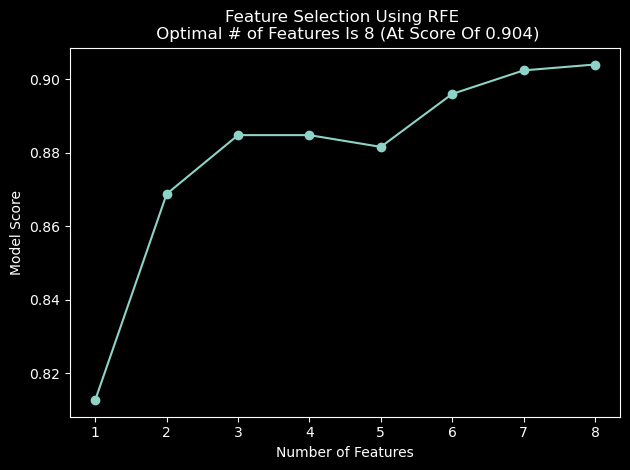

In [12]:
# feature selection

# instantiate regression and feature selecter object
clf = LogisticRegression(max_iter = 1000)
feature_selector = RFECV(clf)

# learn relationships
fit = feature_selector.fit(X_train, y_train)

# determine optimal number of features based on cross validation
optimal_feature_count = feature_selector.n_features_
print(f'Optimal Number of Features: {optimal_feature_count} \n')

# create new dataframe with selected features
X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

# plot results to visually determine best number of features
plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), fit.cv_results_['mean_test_score'], marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection Using RFE \n Optimal # of Features Is {optimal_feature_count} (At Score Of {round(max(fit.cv_results_['mean_test_score']),4)})")
plt.tight_layout()
plt.show()

In [13]:
# train model
clf = LogisticRegression(max_iter = 1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [14]:
# assess model accuracy
y_pred_class = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

In [15]:
# create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class)
print(conf_matrix)

[[106   9]
 [ 13  29]]


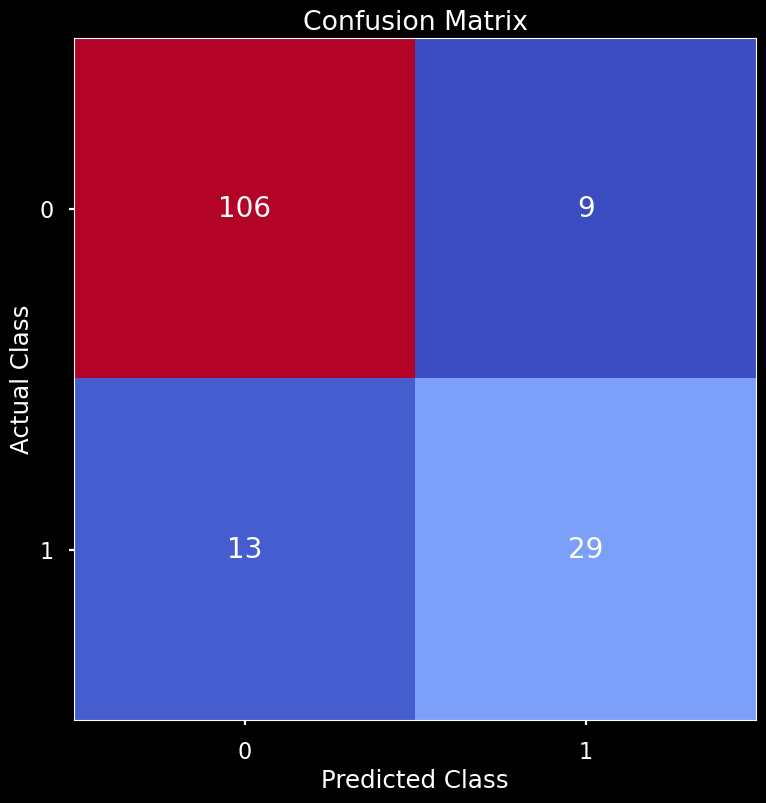

In [16]:
# plot confusion matrix
plt.style.use('seaborn-poster')
plt.matshow(conf_matrix, cmap = 'coolwarm')
plt.gca().xaxis.tick_bottom()
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')

for (i, j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j, i, corr_value, ha = 'center', va = 'center', fontsize = 20)

plt.show()

In [17]:
# accuracy score (number of correct classification out of all attempted classifications)
accuracy_score = accuracy_score(y_test, y_pred_class)
print(f'Accuracy Score: {accuracy_score}')

Accuracy Score: 0.8598726114649682


In [18]:
# precision score (of all observations predicted positive, how many were actually positive)
precision_score = precision_score(y_test, y_pred_class)
print(f'Precision Score: {precision_score}')

Precision Score: 0.7631578947368421


In [19]:
# recall score (of all positive observations, how many were predicted as positive)
recall_score = recall_score(y_test, y_pred_class)
print(f'Recall Score: {recall_score}')

Recall Score: 0.6904761904761905


In [20]:
# F1-Score (harmonic mean of precision and recall) (useful for imbalanced data)
f1_score = f1_score(y_test, y_pred_class)
print(f'F1-Score: {f1_score}')

F1-Score: 0.725


In [21]:
# finding optimal threshold
thresholds = np.arange(0, 1, 0.01)
print(thresholds)
print('\n')

# create empty lists for evaluation
precision_scores = []
recall_scores = []
f1_scores = []

# create for loop
for threshold in thresholds:
    pred_class = (y_pred_prob >= threshold) * 1

    precision = precision_score(y_test, pred_class, zero_division = 0)
    precision_scores.append(precision)

    recall = recall_score(y_test, pred_class)
    recall_scores.append(recall)

    f1 = f1_score(y_test, pred_class)
    f1_scores.append(f1)

# find maximum f1 score
max_f1 = max(f1_scores)
max_f1_index = f1_scores.index(max_f1)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]




TypeError: 'numpy.float64' object is not callable

In [ ]:
# plot thresholds
plt.style.use('seaborn-poster')
plt.plot(thresholds, precision_scores, label = 'Precision', linestyle = '--')
plt.plot(thresholds, recall_scores, label = 'Recall', linestyle = '--')
plt.plot(thresholds, f1_scores, label = 'F1', linewidth = 5)

plt.title(f"""
Finding the Optimal Threshold for Classification Model \n
Max F1: {round(max_f1, 2)} (Threshold = {round(thresholds[max_f1_index], 2)})
"""
)

plt.xlabel('Threshold')
plt.ylabel('Assessment Score')
plt.legend (loc = 'lower left')

plt.tight_layout()
plt.show()

In [ ]:
# use the optimal threshold
optimal_threshold = 0.44 # round(thresholds[max_f1_index], 2)
y_pred_class_opt_thresh = (y_pred_prob >= optimal_threshold) * 1

y_pred_class_opt_thresh